In [ ]:
"""
R004_IMLS_OADS__
|
arxiv_file_formats.ipynb
Created on Fri Nov 15 14:27:05 2024
@author: Rochana Obadage
"""

# URL Extraction Performance Across arXiv File Formats

# `random files selection from each "year,month" combination`

In [ ]:
import os
import random
import glob
import shutil


def copy_file(src_file, dest_dir):
    # Ensure the destination directory exists
    os.makedirs(dest_dir, exist_ok=True)
    
    # Copy the file to the destination directory
    shutil.copy(src_file, dest_dir)
    print(f"Copied {src_file} to {dest_dir}")


def get_random_files(root_dir, num_files=3):
    random_files = {}

    # Loop through each subdirectory in root_dir
    for foldername in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, foldername)
        
        # Check if it's a directory
        if os.path.isdir(folder_path):
            # Get all files in the directory
            files = glob.glob(f'{folder_path}/*.txt')
            
            # Select `num_files` random files if there are enough files
            if len(files) >= num_files:
                random_files[foldername] = random.sample(files, num_files)
            else:
                print(f"Not enough files in {foldername} to select {num_files} files.")

    return random_files

root_dir = 'arxiv-txt-files'
selected_files = get_random_files(root_dir)
for folder, files in selected_files.items():
    print(f"Random files from {folder}:")
    for file_path in files:
        copy_file(file_path, 'arxiv_test_txt_files')
        print(file_path)
    print("=" * 40)

# `conversions`

Assumes the PDF format for each paper is located at /data/pdf

### PDF to TEXT (via `PyMuPDF`)

In [ ]:
!python scripts/pdf_to_text_converter_arxiv.py

### LaTeX to HTML (via `LaTeXML`)

In [ ]:
!./scripts/convert_latex_to_html_new.sh

### PDF to XML (via `GROBID`)

In [ ]:
!python scripts/convert_pdf_using_grobid.py

# `url extraction`

### text

In [15]:
import os
import re
import json

# Directory and output file
input_dir = "data/text"
output_file = "results/text_urls.json"

# Full URL pattern
url_pattern = re.compile(r'''(?xi)
    \b(?:                                           # Start of URL boundary
        (?:https?|ftp|file|data|javascript|mailto|tel|git|ssh|magnet)://  # Protocols
        | www\d{0,3}[.]                             # www. without protocol
        | [a-z0-9.\-]+[.][a-z]{2,4}/               # domain without protocol
    )
    (?:\S+(?::\S*)?@)?                             # user:pass authentication
    (?:
        (?!(?:10|127)(?:\.\d{1,3}){3})              # Exclude private/local networks
        (?!(?:169\.254|192\.168)(?:\.\d{1,3}){2})
        (?!172\.(?:1[6-9]|2\d|3[0-1])(?:\.\d{1,3}){2})
        (?:[1-9]\d?|1\d\d|2[01]\d|22[0-3])         # IP address
        (?:\.(?:1?\d{1,2}|2[0-4]\d|25[0-5])){2}
        (?:\.(?:[1-9]\d?|1\d\d|2[0-4]\d|25[0-4]))
    |
        (?:                                        # Hostname
            (?:
                [a-z0-9\u00a1-\uffff]              # Unicode domain support
                [a-z0-9\u00a1-\uffff_-]{0,62}
            )?
            [a-z0-9\u00a1-\uffff]\.
        )*
        (?:[a-z\u00a1-\uffff]{2,}\.?)              # Domain name
    )
    (?::\d{2,5})?                                  # Port number
    (?:[/?#][^\s]*)?                               # Resource path
    \b                                             # End of URL boundary
    ''')


# Output dictionary
all_urls = {}

# Walk through all .txt files
for root, _, files in os.walk(input_dir):
    if '.ipynb_checkpoints' in root:
        continue
    for fname in files:
        if fname.endswith(".txt"):
            path = os.path.join(root, fname)
            with open(path, "r", encoding="utf-8") as f:
                content = f.read()
                urls = list(set(url_pattern.findall(content)))  # unique URLs
                if urls:
                    relative_path = os.path.relpath(path, input_dir)
                    all_urls[relative_path] = urls

# Save to JSON
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(all_urls, f, indent=2)

print(f"Done. Extracted from {len(all_urls)} files. Saved to {output_file}")


Done. Extracted from 10 files. Saved to results/text_urls.json


### latex

In [25]:
import os
import re
import json
from pylatexenc.latex2text import LatexNodes2Text

# # input folder and output file
input_dir = "data/latex"
output_file = "results/latex_urls.json"

# Full URL pattern
url_pattern = re.compile(r'''(?xi)
    \b(?:                                           # Start of URL boundary
        (?:https?|ftp|file|data|javascript|mailto|tel|git|ssh|magnet)://  # Protocols
        | www\d{0,3}[.]                             # www. without protocol
        | [a-z0-9.\-]+[.][a-z]{2,4}/               # domain without protocol
    )
    (?:\S+(?::\S*)?@)?                             # user:pass authentication
    (?:
        (?!(?:10|127)(?:\.\d{1,3}){3})              # Exclude private/local networks
        (?!(?:169\.254|192\.168)(?:\.\d{1,3}){2})
        (?!172\.(?:1[6-9]|2\d|3[0-1])(?:\.\d{1,3}){2})
        (?:[1-9]\d?|1\d\d|2[01]\d|22[0-3])         # IP address
        (?:\.(?:1?\d{1,2}|2[0-4]\d|25[0-5])){2}
        (?:\.(?:[1-9]\d?|1\d\d|2[0-4]\d|25[0-4]))
    |
        (?:                                        # Hostname
            (?:
                [a-z0-9\u00a1-\uffff]              # Unicode domain support
                [a-z0-9\u00a1-\uffff_-]{0,62}
            )?
            [a-z0-9\u00a1-\uffff]\.
        )*
        (?:[a-z\u00a1-\uffff]{2,}\.?)              # Domain name
    )
    (?::\d{2,5})?                                  # Port number
    (?:[/?#][^\s]*)?                               # Resource path
    \b                                             # End of URL boundary
    ''')
# Also capture \url{} and \urladdr{}
url_commands = [
    re.compile(r'\\url\{([^}]+)\}'),
    re.compile(r'\\urladdr\{([^}]+)\}')
]

# Regex to extract arXiv ID (remove prefix and version)
arxiv_id_pattern = re.compile(r'arxiv-(\d{4}\.\d{4,5})(?:v\d+)?', re.IGNORECASE)

# Output dictionary
extracted_urls = {}

# Walk through all .tex and .bbl files
for root, _, files in os.walk(input_dir):
    if '.ipynb_checkpoints' in root:
        continue
    for fname in files:
        if fname.endswith((".tex", ".bbl")):
            path = os.path.join(root, fname)
            try:
                with open(path, "r", encoding="utf-8") as f:
                    content = f.read()
                    urls = set()

                    # Extract from \url{} and \urladdr{}
                    for pattern in url_commands:
                        urls.update(pattern.findall(content))

                    # Extract from LaTeX-parsed plain text (only for .tex files)
                    plain_text = content
                    if fname.endswith(".tex"):
                        plain_text = LatexNodes2Text().latex_to_text(content)

                    # Extract direct raw URLs
                    urls.update(url_pattern.findall(plain_text))

                    if urls:
                        # Extract arXiv ID from filename or path
                        # match = arxiv_id_pattern.search(fname)
                        # if not match:
                        #     match = arxiv_id_pattern.search(root)
                        match = arxiv_id_pattern.search(path)
                        if match:
                            arxiv_id = match.group(1)
                            if arxiv_id in extracted_urls:
                                extracted_urls[arxiv_id].update(urls)
                            else:
                                extracted_urls[arxiv_id] = set(urls)
                        else:
                            print(f"Warning: Could not extract arXiv ID for file {path}")

            except Exception as e:
                print(f"Error processing {path}: {e}")

# Convert sets to lists and write to JSON
final_output = {k: sorted(list(v)) for k, v in extracted_urls.items()}
os.makedirs(os.path.dirname(output_file), exist_ok=True)
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(final_output, f, indent=2)

print(f"Done. Extracted URLs from {len(final_output)} arXiv papers. Saved to {output_file}")

Done. Extracted URLs from 10 arXiv papers. Saved to results/latex_urls.json


### html

In [31]:
import os
import re
import json
from bs4 import BeautifulSoup

input_dir = "wadl/html"
output_file = "wadl/html_urls.json"
# input_dir = "data/html"
# output_file = "results/html_urls.json"

# Validate arXiv ID format
arxiv_id_pattern = re.compile(r'^\d{4}\.\d{4,5}$', re.IGNORECASE)

all_html_urls = {}

# Each subfolder is named with an arXiv ID
for arxiv_id in os.listdir(input_dir):
    subfolder = os.path.join(input_dir, arxiv_id)

    if not os.path.isdir(subfolder):
        continue

    if not arxiv_id_pattern.match(arxiv_id):
        print(f"Skipping invalid arXiv ID folder: {arxiv_id}")
        continue

    urls = set()

    for fname in os.listdir(subfolder):
        if fname.endswith(".html"):
            path = os.path.join(subfolder, fname)

            try:
                with open(path, 'r', encoding='utf-8') as file:
                    html_content = file.read()

                soup = BeautifulSoup(html_content, 'html.parser')
                page_content = soup.find('div', class_='ltx_page_content') or soup

                for a_tag in page_content.find_all('a', href=True):
                    url = a_tag['href']

                    # Filter out self-links or fragment links
                    if re.search(rf"(arxiv\.org/(abs|pdf|html)/{re.escape(arxiv_id)})", url) or '#' in url:
                        continue

                    urls.add(url.strip())

            except Exception as e:
                print(f"Error processing {path}: {e}")

    if urls:
        all_html_urls[arxiv_id] = sorted(urls)

# Save to JSON
os.makedirs(os.path.dirname(output_file), exist_ok=True)
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(all_html_urls, f, indent=2)

print(f"Done. Extracted URLs from {len(all_html_urls)} arXiv papers. Saved to {output_file}")


Done. Extracted URLs from 10 arXiv papers. Saved to results/html_urls.json


### xml

In [37]:
import os
import re
import json
import glob
from lxml import etree

# Directory setup
input_dir = "data/xml"
output_file = "results/xml_urls.json"

# TEI namespace
NSMAP = {'tei': 'http://www.tei-c.org/ns/1.0'}

def extract_urls_from_tei(xml_file):
    try:
        arxiv_id = re.sub(r'\.tei\.xml$|\.xml$', '', os.path.basename(xml_file))
        tree = etree.parse(xml_file)
        root = tree.getroot()

        elements_with_target = root.xpath("//*[@target]", namespaces=NSMAP)
        urls = set()

        for elem in elements_with_target:
            url = elem.get("target")
            if not url:
                continue

            url = url.strip()
            
            # Filter out TEI references, internal fragments, self-links
            if (
                "tei" in url.lower() or
                url.startswith("#") or
                "kermitt2" in url.lower() or
                arxiv_id in url
            ):
                continue

            urls.add(url)

        return sorted(urls)

    except Exception as e:
        print(f"Error parsing {xml_file}: {e}")
        return []


# Collect results
all_xml_urls = {}

xml_files = glob.glob(os.path.join(input_dir, "*.xml"))

for file in xml_files:
    fname = os.path.basename(file)
    arxiv_id = re.sub(r'\.pdf.tei\.xml$|\.xml$', '', fname)

    urls = extract_urls_from_tei(file)
    # if urls:
    all_xml_urls[arxiv_id] = urls

# Save to JSON
os.makedirs(os.path.dirname(output_file), exist_ok=True)
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(all_xml_urls, f, indent=2)

print(f"Done. Extracted URLs from {len(all_xml_urls)} XML files. Saved to {output_file}")


Done. Extracted URLs from 10 XML files. Saved to results/xml_urls.json


# `visualizations`

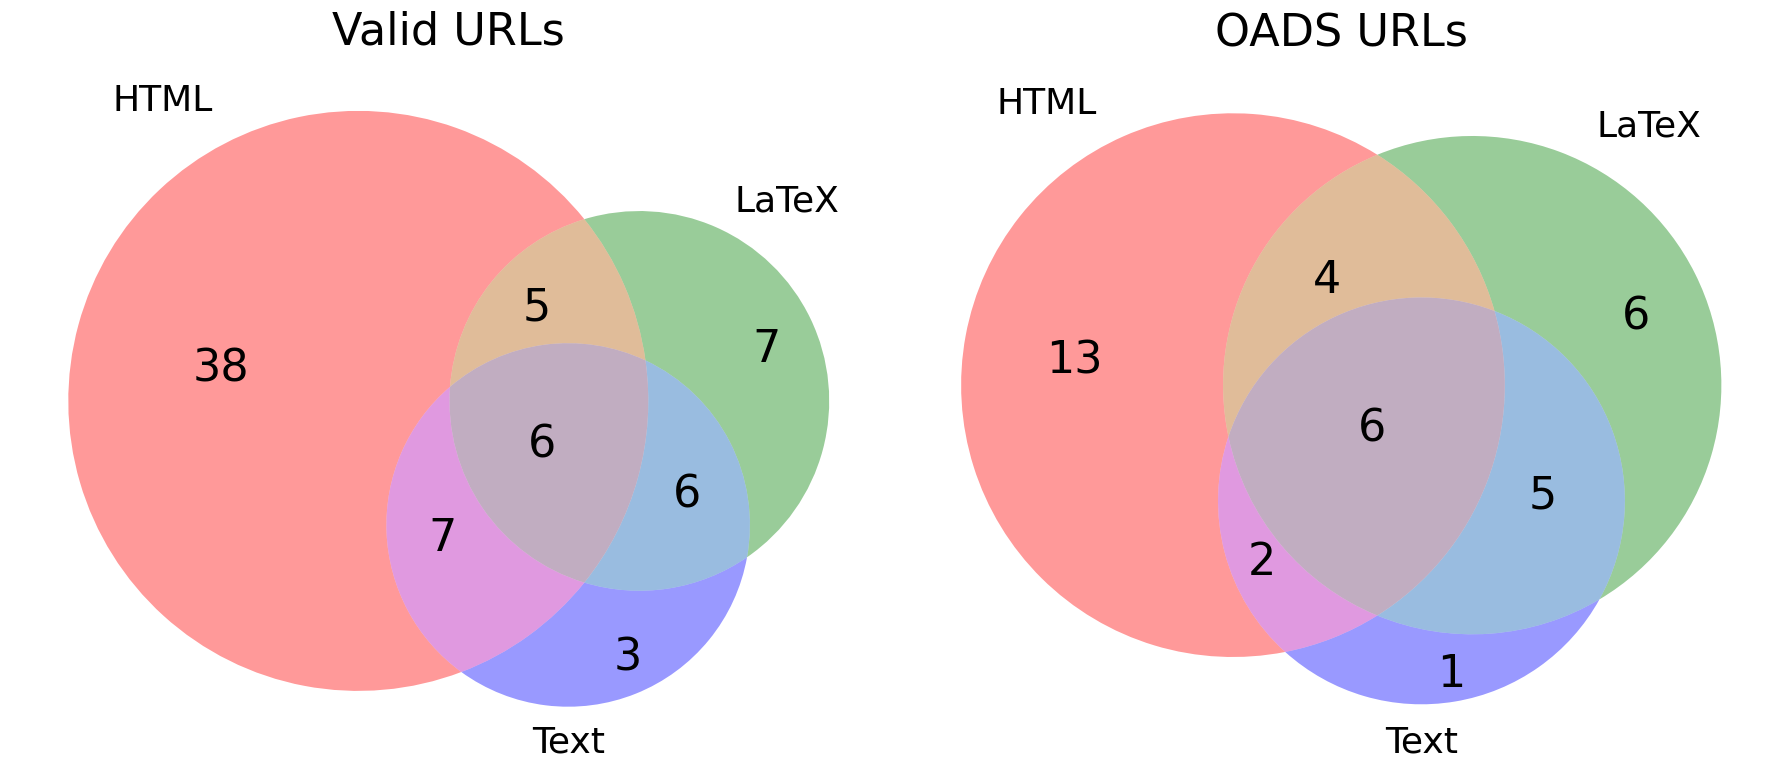

In [3]:
# %matplotlib inline
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# Valid URLs Venn data
valid_subsets = {
    '100': 38,  # HTML only
    '010': 7,   # LaTeX only
    '001': 3,   # Text only
    '110': 5,   # HTML & LaTeX
    '101': 7,   # HTML & Text
    '011': 6,   # LaTeX & Text
    '111': 6    # All three
}

# OADS URLs Venn data
oads_subsets = {
    '100': 13,  # HTML only
    '010': 6,   # LaTeX only
    '001': 1,   # Text only
    '110': 4,   # HTML & LaTeX
    '101': 2,   # HTML & Text
    '011': 5,   # LaTeX & Text
    '111': 6    # All three
}

# Create side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Valid URLs Venn
plt.sca(axs[0])
venn_valid = venn3(subsets=valid_subsets, set_labels=("HTML", "LaTeX", "Text"))
for label in venn_valid.set_labels:
    if label:
        label.set_fontsize(26)
for label in venn_valid.subset_labels:
    if label:
        label.set_fontsize(32)
axs[0].set_title("Valid URLs", fontsize=32)

# OADS URLs Venn
plt.sca(axs[1])
venn_oads = venn3(subsets=oads_subsets, set_labels=("HTML", "LaTeX", "Text"))
for label in venn_oads.set_labels:
    if label:
        label.set_fontsize(26)
for label in venn_oads.subset_labels:
    if label:
        label.set_fontsize(32)
axs[1].set_title("OADS URLs", fontsize=32)

# Adjust layout and save as PDF
plt.tight_layout()
plt.savefig(r"results/url_overlap_venns.pdf", format="pdf", bbox_inches="tight", pad_inches=0.5)
plt.show()


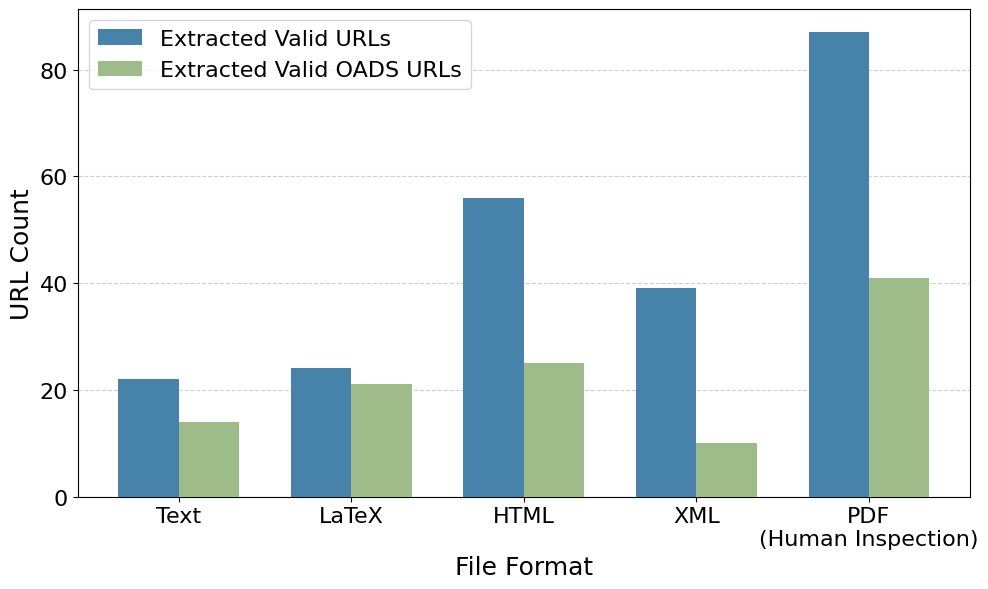

In [4]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

categories = ['Text', 'LaTeX', 'HTML', 'XML', 'PDF\n(Human Inspection)']
extracted_valid_urls = [22, 24, 56, 39, 87]
extracted_valid_oads_urls = [14, 21, 25, 10, 41]

x = np.arange(len(categories))
width = 0.35

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.grid(axis='y', linestyle='--', alpha=0.6, zorder=0)
plt.bar(x - width / 2, extracted_valid_urls, width, label='Extracted Valid URLs', color='#4682A9', zorder=3)
plt.bar(x + width / 2, extracted_valid_oads_urls, width, label='Extracted Valid OADS URLs', color='#9EBC8A', zorder=3)

# plt.title('Comparison of Extracted Valid URLs and OADS URLs', fontsize=14)
plt.xlabel('File Format', fontsize=18)
plt.ylabel('URL Count', fontsize=18)
plt.xticks(x, categories, rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

plt.tight_layout()

# Show the plot
plt.tight_layout()
plt.savefig(r"results/oads_valid_url_counts_bar_chart.pdf", format="pdf", bbox_inches="tight", pad_inches=0.2)
plt.show()


/tmp/ipykernel_4102139/3902050850.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


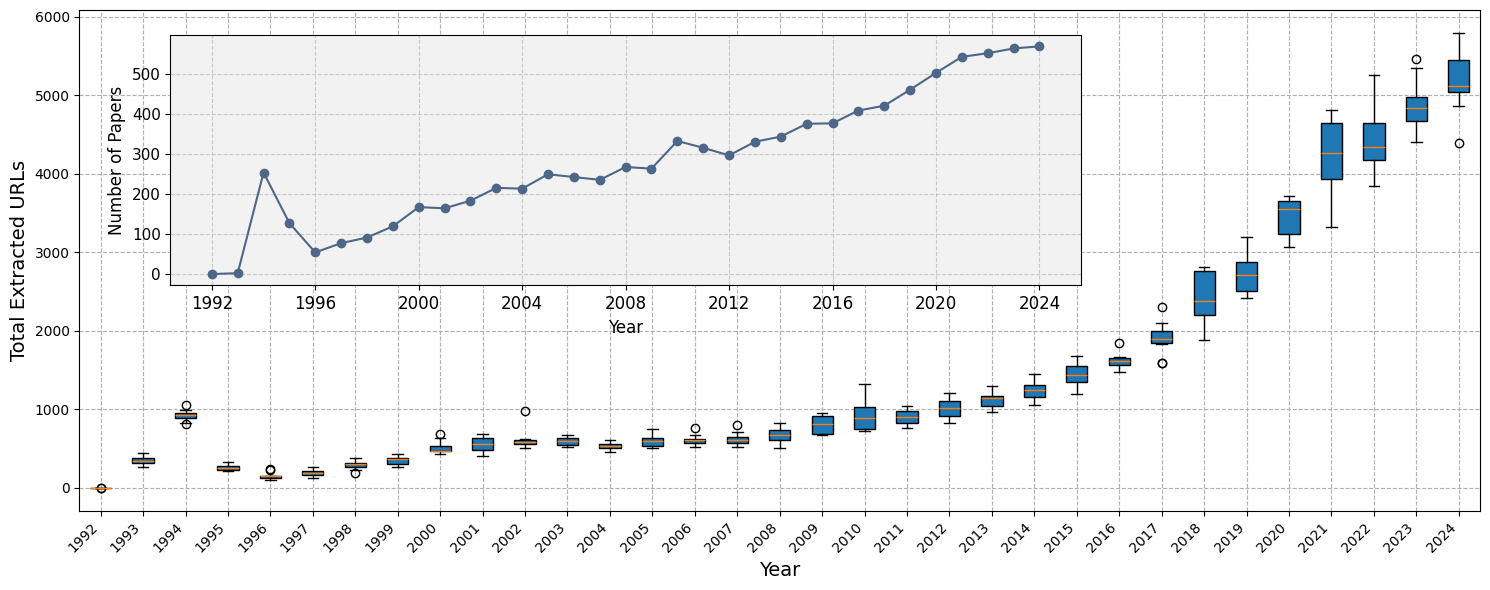

In [8]:
import json
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ---------- Load boxplot data ----------
json_file = r'results/extracted_urls_1000_per_year_10_samples_all_12_folders.json'
with open(json_file, "r", encoding="utf-8") as f:
    data = json.load(f)

boxplot_data = {int(year): values for year, values in data.items()}
del boxplot_data[1991]

sorted_boxplot_data_items = sorted(boxplot_data.items())
sorted_boxplot_dict = dict(sorted_boxplot_data_items)

# ---------- Load inset line plot data ----------
def get_arxiv_year(arxiv_id):
    prefix = int(arxiv_id[:2])
    return 1900 + prefix if prefix >= 90 else 2000 + prefix

json_file = r'results/extracted_urls_1000_per_year.json'
with open(json_file, "r", encoding="utf-8") as f:
    data_inset = json.load(f)

year_paper_counts = {
    get_arxiv_year(year): sum(1 for urls in files.values() if urls != [])
    for year, files in data_inset.items()
}
sorted_year_counts = dict(sorted(year_paper_counts.items()))

# ---------- Main plot ----------
fig, ax = plt.subplots(figsize=(15, 6))

# Boxplot
ax.boxplot(
    list(sorted_boxplot_dict.values()),
    positions=list(sorted_boxplot_dict.keys()),
    patch_artist=True,
    showmeans=False
)

ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Total Extracted URLs", fontsize=14)
ax.set_xticks(list(sorted_boxplot_dict.keys()))
ax.set_xticklabels(list(sorted_boxplot_dict.keys()), rotation=45, ha='right')
ax.grid(True, linestyle='--')

# ---------- Inset plot ----------
# Create inset axes at custom location using bbox_to_anchor (x, y, width, height)
inset_ax = inset_axes(
    ax,
    width="65%",      # width relative to parent
    height="50%",     # height relative to parent
    bbox_to_anchor=(0.065, -0.05, 1, 1),  # (x, y, width, height) where x/y are position offsets
    bbox_transform=ax.transAxes,        # use axes-relative coordinates
    loc='upper left',                   # anchor point inside inset
    borderpad=0
)

# Set background color for the entire inset (canvas + title + ticks)
inset_ax.set_facecolor('#F2F2F2')  # Light gray background
inset_ax.patch.set_alpha(1)        # Ensure opacity is 100%

inset_ax.plot(
    sorted_year_counts.keys(),
    sorted_year_counts.values(),
    marker='o',
    linestyle='-',
    color='#4E6688'
)
# inset_ax.set_title("Number of papers with at least one extracted URL (1,000 papers sampled per year)", fontsize=14)
inset_ax.set_xticks(range(1992, 2025, 4))
inset_ax.tick_params(axis='x', labelrotation=0, labelsize=12)
inset_ax.tick_params(axis='y', labelsize=11)
inset_ax.grid(True, linestyle='--', alpha=0.6)
inset_ax.set_xlabel("Year", fontsize=12)
inset_ax.set_ylabel("Number of Papers", fontsize=12)


# ---------- Save and show ----------
plt.tight_layout()
plt.savefig("results/box_plot_with_inset.pdf", format="pdf", bbox_inches="tight", pad_inches=0.2)
plt.show()
